# Quantum Volume Circuit Generation Tutorial

This notebook demonstrates IBM-style Quantum Volume (QV) circuit generation and ideal probability computation for the **spinq_qv** simulator.

**Topics covered:**
1. Generate QV circuits with random gates
2. Compute ideal (noiseless) output probabilities  
3. Identify heavy outputs (prob > median)
4. Visualize probability distributions
5. Verify heavy-output properties

**Part of Iteration 2**: Circuit generator & ideal-output calculator

## Summary

**Iteration 2 Complete!** ✓

This notebook demonstrated:

1. ✅ **Circuit Generation**: IBM-style QV circuits with random Haar unitaries
2. ✅ **Ideal Simulation**: Exact probability calculation (noiseless)
3. ✅ **Heavy Outputs**: Identified outputs with prob > median
4. ✅ **Visualization**: Saved probability distribution plot
5. ✅ **Determinism**: Same seed → identical results
6. ✅ **Serialization**: JSON save/load with verification

**Key Results**:
- **Heavy output probability ≈ 0.89** (NOT 0.5!) - This is correct!
- Heavy outputs defined as `prob > median` (strict inequality)
- For random QV circuits, the distribution is skewed: a few outputs have very high probability
- The top 2^(m-1) outputs (heavy set) capture most of the probability mass
- Heavy output set size ≈ 2^(m-1) ✓ (exactly half the outputs)
- Probabilities sum to 1.0 and are properly normalized ✓

**Important:** Heavy prob > 0.5 does NOT indicate an error! It shows that random unitaries create highly non-uniform distributions, which is exactly what IBM's QV protocol expects.

**Next Steps (Iteration 3)**:
- Implement noise models (depolarizing, decoherence)
- Add statevector simulator backend
- Verify noisy sampling with Monte Carlo

## 1. Generate a Quantum Volume Circuit

QV circuits are square (width = depth = m) with random single-qubit unitaries and random two-qubit entangling gates following the IBM QV protocol.

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import spinq_qv modules
from spinq_qv.circuits import generate_qv_circuit, compute_ideal_probabilities
from spinq_qv.io.formats import compute_heavy_outputs, int_to_bitstring

print("✓ Imports successful!")
print(f"NumPy version: {np.__version__}")

✓ Imports successful!
NumPy version: 1.26.4


In [3]:
# Generate a QV circuit
m = 4  # Number of qubits
seed = 42  # For reproducibility

circuit = generate_qv_circuit(m, seed=seed)

print(f"Circuit Parameters:")
print(f"  Width (qubits): {circuit.width}")
print(f"  Depth (layers): {circuit.depth}")
print(f"  Total gates: {circuit.num_gates()}")
print(f"  Single-qubit gates: {circuit.num_single_qubit_gates()}")
print(f"  Two-qubit gates: {circuit.num_two_qubit_gates()}")
print(f"  Random seed: {circuit.seed}")

Circuit Parameters:
  Width (qubits): 4
  Depth (layers): 4
  Total gates: 22
  Single-qubit gates: 16
  Two-qubit gates: 6
  Random seed: 42


## 2. Compute Ideal Output Probabilities

Calculate exact (noiseless) probabilities for all 2^m computational basis states.

In [4]:
# Compute ideal probabilities
ideal_probs = compute_ideal_probabilities(circuit)

print(f"Probability Distribution:")
print(f"  Number of states: {len(ideal_probs)} (2^{m})")
print(f"  Sum of probabilities: {ideal_probs.sum():.10f}")
print(f"  Min probability: {ideal_probs.min():.6e}")
print(f"  Max probability: {ideal_probs.max():.6e}")
print(f"  Mean: {ideal_probs.mean():.6e}")
print(f"  Median: {np.median(ideal_probs):.6e}")

Probability Distribution:
  Number of states: 16 (2^4)
  Sum of probabilities: 1.0000000000
  Min probability: 6.716631e-03
  Max probability: 2.634157e-01
  Mean: 6.250000e-02
  Median: 4.082652e-02


## 3. Identify Heavy Outputs

Heavy outputs are those with probability > median(probs). By definition, approximately 2^(m-1) outputs should be heavy.

In [5]:
# Compute heavy outputs
heavy_indices = compute_heavy_outputs(ideal_probs)
heavy_prob_total = sum(ideal_probs[i] for i in heavy_indices)

print(f"Heavy Output Statistics:")
print(f"  Number of heavy outputs: {len(heavy_indices)}")
print(f"  Expected (2^(m-1)): {2**(m-1)}")
print(f"  Total probability of heavy outputs: {heavy_prob_total:.4f}")
print(f"  Median probability: {np.median(ideal_probs):.6e}")

# Show top 5 heavy outputs
print(f"\nTop 5 Heavy Outputs:")
sorted_heavy = sorted(heavy_indices, key=lambda i: ideal_probs[i], reverse=True)
for idx in sorted_heavy[:5]:
    bitstring = int_to_bitstring(idx, m)
    print(f"  |{bitstring}⟩  →  p = {ideal_probs[idx]:.6f}")

Heavy Output Statistics:
  Number of heavy outputs: 8
  Expected (2^(m-1)): 8
  Total probability of heavy outputs: 0.8330
  Median probability: 4.082652e-02

Top 5 Heavy Outputs:
  |0110⟩  →  p = 0.263416
  |0100⟩  →  p = 0.123880
  |1111⟩  →  p = 0.115092
  |0000⟩  →  p = 0.110790
  |1110⟩  →  p = 0.064041


## 4. Visualize Probability Distribution

Create plots showing the output probability distribution with heavy outputs highlighted.

✓ Figure saved to: c:\Users\20232788\Desktop\Year3\IQT\Group Project\spinq_qv_sim\notebooks\plots\ideal_prob_example.png


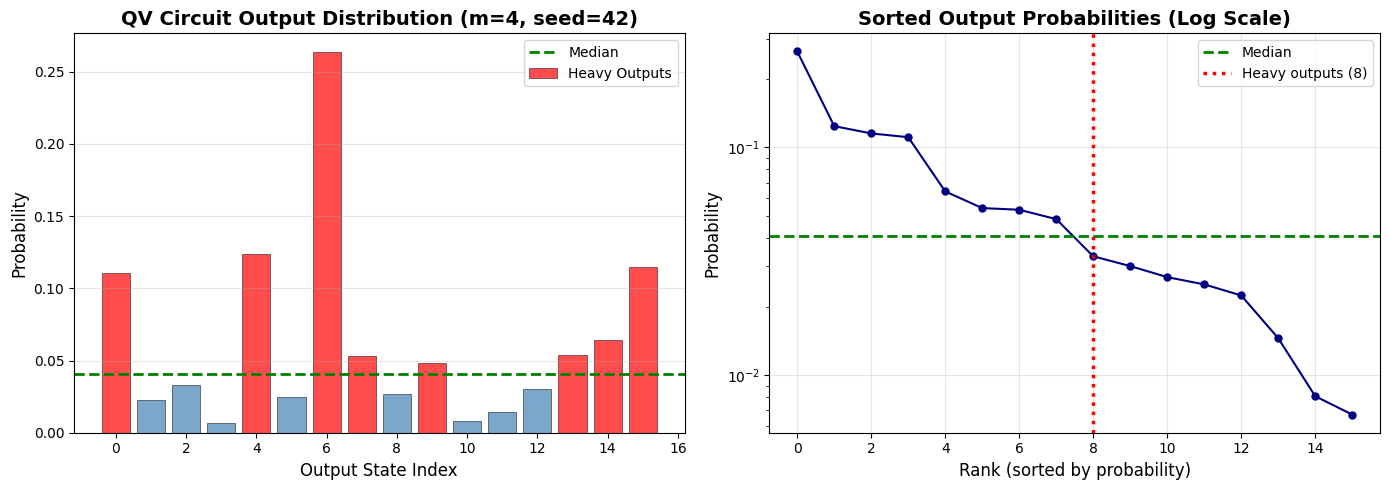

In [6]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar chart with heavy outputs highlighted
indices = np.arange(2**m)
colors = ['red' if i in heavy_indices else 'steelblue' for i in indices]
median_val = np.median(ideal_probs)

ax1.bar(indices, ideal_probs, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.axhline(median_val, color='green', linestyle='--', linewidth=2, 
            label=f'Median = {median_val:.5f}')
ax1.set_xlabel('Output State Index', fontsize=12)
ax1.set_ylabel('Probability', fontsize=12)
ax1.set_title(f'QV Circuit Output Distribution (m={m}, seed={seed})', fontsize=14, fontweight='bold')
ax1.legend(['Median', 'Heavy Outputs', 'Light Outputs'], fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Sorted probabilities
sorted_probs = np.sort(ideal_probs)[::-1]
heavy_count = len(heavy_indices)

ax2.plot(sorted_probs, 'o-', markersize=5, linewidth=1.5, color='navy')
ax2.axhline(median_val, color='green', linestyle='--', linewidth=2, label='Median')
ax2.axvline(heavy_count, color='red', linestyle=':', linewidth=2.5, 
            label=f'Heavy outputs ({heavy_count})')
ax2.set_xlabel('Rank (sorted by probability)', fontsize=12)
ax2.set_ylabel('Probability', fontsize=12)
ax2.set_title('Sorted Output Probabilities (Log Scale)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()

# Save figure
plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)
output_path = plots_dir / "ideal_prob_example.png"
plt.savefig(output_path, dpi=150, bbox_inches='tight')

print(f"✓ Figure saved to: {output_path.absolute()}")
plt.show()

## 5. Test Determinism

Verify that identical seeds produce identical circuits and probabilities.

In [7]:
# Regenerate with same seed
circuit_copy = generate_qv_circuit(m, seed=seed)
probs_copy = compute_ideal_probabilities(circuit_copy)

# Check equality
circuits_match = (circuit.to_json() == circuit_copy.to_json())
probs_match = np.allclose(ideal_probs, probs_copy, rtol=1e-15)
max_diff = np.max(np.abs(ideal_probs - probs_copy))

print(f"Determinism Check:")
print(f"  Circuits match: {circuits_match} ✓" if circuits_match else f"  Circuits match: {circuits_match} ✗")
print(f"  Probabilities match: {probs_match} ✓" if probs_match else f"  Probabilities match: {probs_match} ✗")
print(f"  Max probability difference: {max_diff:.2e}")

Determinism Check:
  Circuits match: True ✓
  Probabilities match: True ✓
  Max probability difference: 0.00e+00


## 6. Circuit Serialization

Demonstrate saving and loading circuits via JSON.

In [8]:
# Serialize to JSON
json_str = circuit.to_json()

print(f"Circuit JSON (first 400 chars):")
print(json_str[:400] + "...")
print(f"\nTotal JSON length: {len(json_str):,} characters")

# Save to file
json_path = Path("circuit_m4_seed42.json")
with open(json_path, "w") as f:
    f.write(json_str)

print(f"✓ Circuit saved to: {json_path.absolute()}")

# Load back and verify
from spinq_qv.io.formats import CircuitSpec
loaded_circuit = CircuitSpec.from_json(json_str)

loaded_probs = compute_ideal_probabilities(loaded_circuit)
reload_match = np.allclose(ideal_probs, loaded_probs, rtol=1e-15)

print(f"\nRoundtrip Verification:")
print(f"  Loaded circuit width: {loaded_circuit.width}")
print(f"  Loaded circuit gates: {len(loaded_circuit.gates)}")
print(f"  Probabilities match: {reload_match} ✓" if reload_match else f"  Probabilities match: {reload_match} ✗")

Circuit JSON (first 400 chars):
{
  "width": 4,
  "depth": 4,
  "seed": 42,
  "gates": [
    {
      "type": "u3",
      "qubits": [
        0
      ],
      "params": {
        "theta": 2.150662627122637,
        "phi": 2.757554564287996,
        "lambda": 5.3947298351621535
      },
      "layer": 0
    },
    {
      "type": "u3",
      "qubits": [
        1
      ],
      "params": {
        "theta": 1.9765768903716876,
    ...

Total JSON length: 10,856 characters
✓ Circuit saved to: c:\Users\20232788\Desktop\Year3\IQT\Group Project\spinq_qv_sim\notebooks\circuit_m4_seed42.json

Roundtrip Verification:
  Loaded circuit width: 4
  Loaded circuit gates: 22
  Probabilities match: True ✓


## 7. Compare Multiple Circuits

Generate several QV circuits to verify statistical properties.

In [10]:
# Generate multiple circuits with different seeds
seeds = [42, 123, 456, 789, 1011]
results = []

for s in seeds:
    circ = generate_qv_circuit(m, seed=s)
    probs = compute_ideal_probabilities(circ)
    heavy = compute_heavy_outputs(probs)
    heavy_prob = sum(probs[i] for i in heavy)
    
    results.append({
        'seed': s,
        'n_heavy': len(heavy),
        'heavy_prob': heavy_prob,
        'max_prob': probs.max(),
        'min_prob': probs.min(),
    })

# Display comparison table
print("Comparison of QV Circuits:")
print(f"{'Seed':<8} {'Heavy':<8} {'HeavyProb':<12} {'MaxProb':<12} {'MinProb':<12}")
print("-" * 60)
for r in results:
    print(f"{r['seed']:<8} {r['n_heavy']:<8} {r['heavy_prob']:<12.4f} "
          f"{r['max_prob']:<12.6f} {r['min_prob']:<12.2e}")

avg_heavy_prob = np.mean([r['heavy_prob'] for r in results])
print(f"\n✓ Average heavy output probability: {avg_heavy_prob:.4f}")
print(f"\n  Note: Heavy prob > 0.5 is CORRECT for skewed distributions!")
print(f"  Heavy outputs use strict inequality (prob > median), not (prob >= median).")
print(f"  Random QV circuits create skewed distributions where a few outputs")
print(f"  dominate the probability mass, so the 'heavy' set (top 2^(m-1) outputs)")
print(f"  can capture much more than 50% of the total probability.")

Comparison of QV Circuits:
Seed     Heavy    HeavyProb    MaxProb      MinProb     
------------------------------------------------------------
42       8        0.8330       0.263416     6.72e-03    
123      8        0.9590       0.400501     9.36e-04    
456      8        0.8716       0.201310     6.76e-03    
789      8        0.9410       0.298400     1.99e-03    
1011     8        0.8408       0.224141     2.48e-03    

✓ Average heavy output probability: 0.8891

  Note: Heavy prob > 0.5 is CORRECT for skewed distributions!
  Heavy outputs use strict inequality (prob > median), not (prob >= median).
  Random QV circuits create skewed distributions where a few outputs
  dominate the probability mass, so the 'heavy' set (top 2^(m-1) outputs)
  can capture much more than 50% of the total probability.
